In [7]:
# !pip install fvgp~=4.3.0
import numpy as np
import matplotlib.pyplot as plt
from fvgp import GP
import time

# %load_ext autoreload
# %autoreload 2

from itertools import product
x_pred1D = np.linspace(0, 1, 1000).reshape(-1, 1)

import random

TypeError: list indices must be integers or slices, not tuple

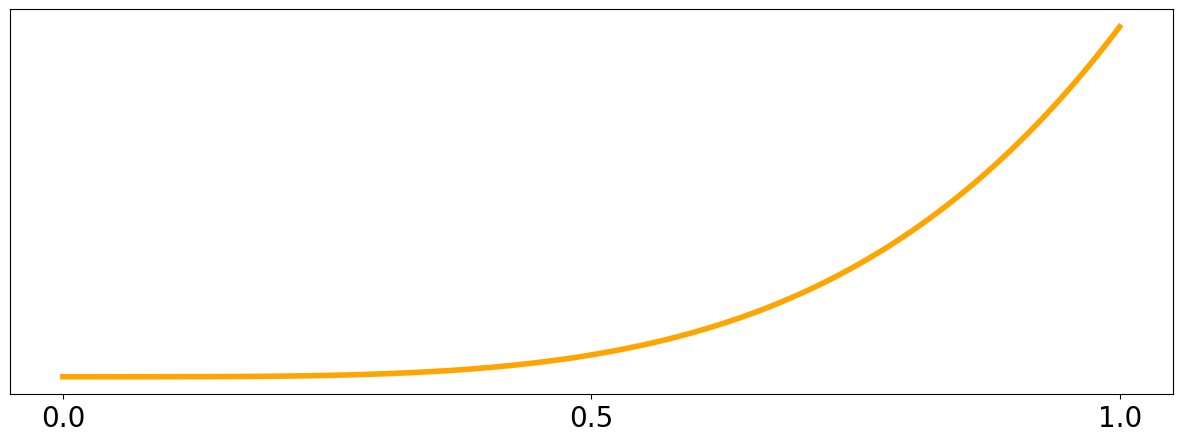

In [8]:
x = np.linspace(0,600,1000)
a = 5
p = 4
b = -30
def f1(x):
    return a * x ** p + b

x_data = [round(random.uniform(0,5), 2) for _ in range(10)] # radii
y_data = [round(f1(r), 3) for r in x_data]

plt.figure(figsize = (15,5))
plt.xticks([0.,0.5,1.0])
plt.yticks([-2,-1,0.,1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(x_pred1D, f1(x_pred1D), color = 'orange', linewidth = 4)
plt.scatter(x_data[:,0],y_data, color = 'black')

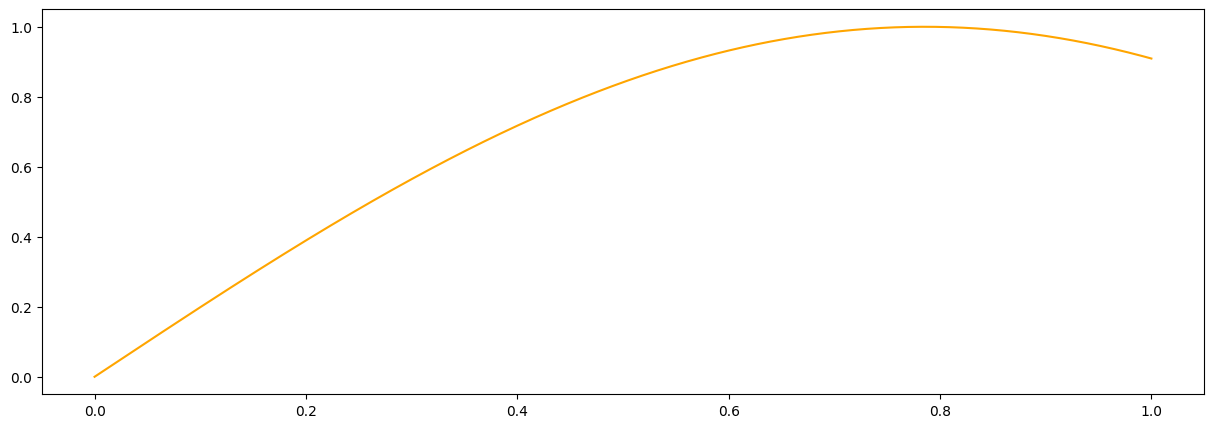

In [9]:
from fvgp.gp_kernels import *


# This is a simple noise function but can be arbitrarily complex using many hyperparameters.
# The noise function always has to return a matrix, because the noise can have covariances.
def my_noise(x, hps):
    return np.diag(np.zeros((len(x))) + hps[2])

# stationary
# The kernel follows the mathematical definition of a kernel. This means
# there is no limit to the variety of kernels you can define
def skernel(x1,x2,hps):
    d = get_distance_matrix(x1,x2)
    return hps[0] * matern_kernel_diff1(d, hps[1])

# This is a simple mean function but it can be arbitrarily complex using many hyperparameters.
def meanf(x,hps):
    return np.sin(hps[3] * x[:,0])


# it is a good idea to plot the prior mean function to make sure we did not mess up
plt.figure(figsize = (15,5))
plt.plot(x_pred1D, meanf(x_pred1D, np.array([1.,1.,5.0,2.])), color = 'orange', label = 'task1')

In [10]:
my_gp1 = GP(x_data,y_data,
            init_hyperparameters = np.ones((4))/10.,  # we need enough of those for kernel, noise and prior mean functions
            noise_variances=np.ones(y_data.shape) * 0.01, #provding noise variances and a noise function will raise a warning 
            compute_device='cpu', 
            gp_kernel_function=skernel, 
            gp_kernel_function_grad=None, 
            gp_mean_function=meanf, 
            gp_mean_function_grad=None,
            #gp_noise_function=my_noise,
            gp2Scale = False,
            calc_inv=False, 
            ram_economy=False, 
            args=None,
            )

hps_bounds = np.array([[0.01,10.], #signal variance for the kernel
                       [0.01,10.], #length scale for the kernel
                       [0.001,0.1],  #noise
                       [0.01,1.]  #mean
                      ])


my_gp1.update_gp_data(x_data, y_data, noise_variances_new=np.ones(y_data.shape) * 0.01)
print("Standard Training")
my_gp1.train(hyperparameter_bounds=hps_bounds)
print("Global Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='global')
print("hps: ", my_gp1.get_hyperparameters())
print("Local Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='local')
print(my_gp1.get_hyperparameters())
print("MCMC Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='mcmc', max_iter=1000)
print("HGDL Training")
print(my_gp1.get_hyperparameters())
my_gp1.train(hyperparameter_bounds=hps_bounds, method='hgdl', max_iter=10)


AttributeError: 'list' object has no attribute 'shape'

In [11]:
# Let's make a prediction
x_pred = np.linspace(0,1,1000)

mean1 = my_gp1.posterior_mean(x_pred.reshape(-1,1))['f(x)']
var1 = my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=False)['v(x)']
var1 = my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=True, add_noise=False)['v(x)']

mean1 = my_gp1.posterior_mean(x_pred.reshape(-1,1))['f(x)']
var1 = my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)['v(x)']
plt.figure(figsize = (16,10))
plt.plot(x_pred, mean1, label = 'posterior mean', linewidth = 4)
plt.plot(x_pred1D, f1(x_pred1D), label = 'latent function', linewidth = 4)
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = 'grey', label = 'var')
plt.scatter(x_data, y_data, color = 'black')

# looking at some validation metrics
print(my_gp1.rmse(x_pred1D, f1(x_pred1D)))
print(my_gp1.crps(x_pred1D, f1(x_pred1D)))

NameError: name 'my_gp1' is not defined

In [12]:
relative_entropy = my_gp1.gp_relative_information_entropy_set(x_pred.reshape(-1,1))['RIE']

NameError: name 'my_gp1' is not defined

In [13]:
plt.figure(figsize = (16,10))
plt.plot(x_pred, relative_entropy, label =  'relative_entropy', linewidth = 4)
plt.scatter(x_data, y_data, color = 'black')
plt.legend()

NameError: name 'relative_entropy' is not defined

<Figure size 1600x1000 with 0 Axes>

In [14]:
# We can ask mutual inforation and total correlation there is given some test data
x_test = np.array([[0.45],[0.45]])
print('MI: ', my_gp1.gp_mutual_information(x_test))
print('TC: ',my_gp1.gp_total_correlation(x_test))
my_gp1.gp_entropy(x_test)
my_gp1.gp_entropy_grad(x_test, 0)
my_gp1.gp_kl_div(x_test, np.ones((len(x_test))), np.identity((len(x_test))))
my_gp1.gp_kl_div_grad(x_test, np.ones((len(x_test))), np.identity((len(x_test))), 0)
my_gp1.gp_relative_information_entropy(x_test)
my_gp1.gp_relative_information_entropy_set(x_test)
my_gp1.posterior_covariance(x_test)
my_gp1.posterior_covariance_grad(x_test)
my_gp1.posterior_mean(x_test)
my_gp1.posterior_mean_grad(x_test)
my_gp1.posterior_probability(x_test, np.ones((len(x_test))), np.identity((len(x_test))))
my_gp1.posterior_probability_grad(x_test, np.ones((len(x_test))), np.identity((len(x_test))),0)


NameError: name 'my_gp1' is not defined